# Imports

In [1]:
# %% Imports
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.utilities.model_summary import summarize
import torch
import numpy as np
from datamodules import SimpleMicroDataModule, AlignedMicroDataModule
from models import CNNTransformer, Transformer, TCN_classifier
import augmentations as augs

import os
import sys
sys.path.append('..')
from alignment import alignment_utils as utils
from alignment.AlignCCA import AlignCCA

# Define data module

In [2]:
data_filename = os.path.expanduser('~/data/pt_decoding_data_S62.pkl')
pt_data = utils.load_pkl(data_filename)

In [3]:
pt = 'S14'
p_ind = -1
lab_type = 'phon'
algn_type = 'phon_seq'
tar_data, pre_data = utils.decoding_data_from_dict(pt_data, pt, p_ind,
                                                   lab_type=lab_type,
                                                   algn_type=algn_type)
print([d.shape for d in tar_data])
print([[d.shape for d in p] for p in pre_data])

[(432, 200, 111), (432,), (432, 3)]
[[(444, 200, 111), (444,), (444, 3)], [(453, 200, 63), (453,), (453, 3)], [(138, 200, 149), (138,), (138, 3)], [(453, 200, 74), (453,), (453, 3)], [(411, 200, 144), (411,), (411, 3)], [(423, 200, 171), (423,), (423, 3)], [(534, 200, 201), (534,), (534, 3)]]


In [5]:
# dummy data
# n_samples = 144
# n_timepoints = 200
# n_features = 111
fs = 200 # Hz
augmentations = [augs.time_warping, augs.time_masking, augs.time_shifting, augs.noise_jitter, augs.scaling]
# augmentations = None
# data = torch.rand(n_samples, n_timepoints, n_features)
# labels = torch.randint(0, 9, (n_samples,))
# data = torch.Tensor(all_pt_dict['S14']['X1'])
# labels = torch.Tensor(all_pt_dict['S14']['y1']).long() - 1
data = torch.Tensor(tar_data[0])
labels = torch.Tensor(tar_data[1]).long() - 1
align_labels = torch.Tensor(tar_data[2]).long() - 1
pool_data = [(torch.Tensor(p[0]), torch.Tensor(p[1]).long() - 1, torch.Tensor(p[2]).long() - 1) for p in pre_data]
# data = torch.Tensor(all_pt_dict['S14']['X_collapsed'])
# labels = torch.Tensor(all_pt_dict['S14']['y_phon_collapsed']).long() - 1

# create the data module
batch_size = -1
n_folds = 20
val_size = 0.1
# dm = SimpleMicroDataModule(data, labels, batch_size=batch_size, folds=n_folds,
#                            val_size=val_size, augmentations=augmentations, data_path=os.path.expanduser('~/workspace/transformer_data/pt_specific'))
dm = AlignedMicroDataModule(data, labels, align_labels, pool_data, AlignCCA,
                            batch_size=batch_size, folds=n_folds, val_size=val_size,
                            augmentations=augmentations, data_path=os.path.expanduser('~/workspace/transformer_data'))
dm.setup()

KeyboardInterrupt: 

# Define model

In [5]:
# model parameters
in_channels = data.shape[-1]
num_classes = 9
d_model = 128
# d_model = data.shape[-1]
kernel_time = 50  # ms
kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
stride_time = 25  # ms
stride = int(stride_time * fs / 1000)  # stride length in samples
padding = 0
n_head = 8
num_layers = 2
# dim_fc = 64
dim_fc = [128, 64, 32]
cnn_dropout = 0.2
tform_dropout = 0.4
learning_rate = 1e-3
l2_reg = 1e-5
gclip_val = 0.5
activ = True

In [6]:
from pytorch_lightning.utilities.model_summary import summarize

In [7]:
# sum_model = CNNTransformer(in_channels, num_classes, d_model, kernel_size, stride, padding,
#                            n_head, num_layers, dim_fc, cnn_dropout, tform_dropout, learning_rate)
sum_model = TCN_classifier(in_channels, num_classes, dim_fc, kernel_size, stride, padding,
                           cnn_dropout, learning_rate, l2_reg)
print(summarize(sum_model))
# sum_model = Transformer(in_channels, num_classes, d_model, kernel_size, stride, padding,
#                            n_head, num_layers, dim_fc, dropout, learning_rate)
# print(summarize(sum_model))

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | temporal_conv | TemporalConv     | 142 K  | train
1 | fc            | Sequential       | 10.6 K | train
2 | criterion     | CrossEntropyLoss | 0      | train
-----------------------------------------------------------
153 K     Trainable params
0         Non-trainable params
153 K     Total params
0.612     Total estimated model params size (MB)


# Train model

In [8]:
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", "The number of training batches.*")

In [9]:
# instantiate the trainer
# max_epochs = 500
# es_pat = max_steps // 20
max_steps = 500
es_pat = 25
warmup = 50
# callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
log_dir = os.path.expanduser('~/workspace/transformer_data/transformer_logs')

In [38]:
# class MetricCollector(L.Callback):
#     def __init__(self):
#         self.metrics = {}
#     
#     def on_validation_epoch_end(self, trainer, pl_module):
#         self.metrics['val_loss'] = trainer.logger.metrics['val_loss']
#         self.metrics['val_acc'] = trainer.logger.metrics['val_acc']
#     
#     def on_test_epoch_end(self, trainer, pl_module):
#         self.metrics['test_loss'] = trainer.logger.metrics['test_loss']
#         self.metrics['test_acc'] = trainer.logger.metrics['test_acc']

In [10]:
from torchmetrics.functional.classification import multiclass_confusion_matrix

def cmat_acc(y_hat, y, num_classes):
    y_pred = torch.argmax(y_hat, dim=1)
    cmat = multiclass_confusion_matrix(y_pred, y, num_classes)
    acc_cmat = cmat.diag().sum() / cmat.sum()
    return acc_cmat

In [11]:
# train the model
n_iters = 1
iter_accs = []
for i in range(n_iters):
    # dm.setup()
    
    fold_accs = []
    # y_pred_all = []
    # y_test_all = []
    for fold in range(n_folds):
        if fold > 2:
            break
        dm.set_fold(fold)
        # print(dm.current_fold)
        
        # instantiate the model
        in_channels = dm.get_data_shape()[-1]
        # print(in_channels)
        # model = CNNTransformer(in_channels, num_classes, d_model, kernel_size, stride, padding,
        #                        n_head, num_layers, dim_fc, cnn_dropout, tform_dropout, learning_rate,
        #                        warmup, max_steps, l2_reg, activation=activ)
        model = TCN_classifier(in_channels, num_classes, dim_fc, kernel_size, stride, padding,
                                   cnn_dropout, learning_rate, l2_reg, activation=activ)
        
        # model.current_fold = fold
        callbacks = [
            ModelCheckpoint(monitor='val_loss'),
            EarlyStopping(monitor='val_loss', patience=es_pat),
            LearningRateMonitor(logging_interval='epoch'),
            ]
        trainer = L.Trainer(default_root_dir=log_dir,
                            # max_epochs=max_epochs,
                            max_steps=max_steps,
                            gradient_clip_val=gclip_val,
                            accelerator='auto',
                            callbacks=callbacks,
                            logger=True,
                            enable_model_summary=False,
                            enable_progress_bar=False,
                           )
        # # trainer.fit(model, dm)
        trainer.fit(model=model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())
        print(trainer.logged_metrics)
        # print the training metrics from the best model checkpoint
        # print(f'Fold {fold} best model metrics:')
        # print(trainer.checkpoint_callback.best_model_score)


        # trainer.test(model, dm)
        # model = CNNTransformer.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
        trainer.test(model=model, dataloaders=dm.test_dataloader(), ckpt_path='best')
        # trainer.test(dataloaders=dm.test_dataloader(), ckpt_path='best')

        # test_pred = model(dm.test_dataloader().dataset.tensors[0])
        # test_pred = trainer.predict(model, dm.test_dataloader(), ckpt_path='best)[0]
        # test_pred = torch.argmax(test_pred, dim=1)
        # print(test_pred)
        # y_pred_all.extend(test_pred)
        # y_test_all.extend(dm.test_dataloader().dataset.tensors[1])
        
        fold_accs.append(trainer.logged_metrics['test_acc'])
    
        # save loss information
        # loss_dict = trainer.logger.metrics
        # loss_dict['fold'] = fold
        # loss_dict['model'] = model
    # acc = cmat_acc(torch.stack(y_pred_all), torch.stack(y_test_all), num_classes)
    # print(acc)
    # iter_accs.append(acc)
    # print(f'Averaged accuracy: {sum(fold_accs) / len(fold_accs)}')
    iter_accs.append(fold_accs)
    print(np.mean(fold_accs))
# print(sum(iter_accs) / len(iter_accs), iter_accs)
print(iter_accs)

/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` 

{'train_loss': tensor(0.1739), 'train_acc': tensor(0.9904), 'val_loss': tensor(1.7967), 'val_acc': tensor(0.2857)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.375
        test_loss           1.7319660186767578
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_848/checkpoints/epoch=66-step=134.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_848/checkpoints/epoch=66-step=134.ckpt


{'train_loss': tensor(0.5582), 'train_acc': tensor(0.9135), 'val_loss': tensor(2.0847), 'val_acc': tensor(0.2143)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.375
        test_loss           1.6023768186569214
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_849/checkpoints/epoch=163-step=328.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_849/checkpoints/epoch=163-step=328.ckpt


{'train_loss': tensor(0.0823), 'train_acc': tensor(0.9942), 'val_loss': tensor(1.6062), 'val_acc': tensor(0.3571)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.625
        test_loss           1.6224404573440552
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.45833334
[[tensor(0.3750), tensor(0.3750), tensor(0.6250)]]


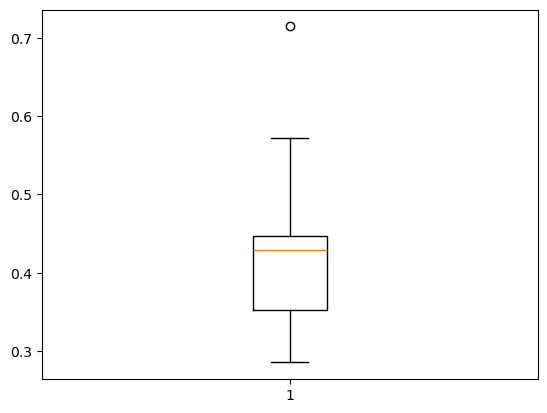

In [13]:
import matplotlib.pyplot as plt
from torch import tensor
# test = [[tensor(0.5000), tensor(0.3636), tensor(0.2727), tensor(0.4545), tensor(0.3182), tensor(0.4545), tensor(0.4091), tensor(0.2273), tensor(0.2727), tensor(0.4091), tensor(0.2727), tensor(0.3182), tensor(0.3333), tensor(0.3333), tensor(0.4762), tensor(0.3333), tensor(0.2857), tensor(0.3810), tensor(0.3810), tensor(0.3810)]]
plt.boxplot(fold_accs)
plt.show()

In [14]:

np.mean(fold_accs)

0.20790043